## Imports

In [1]:
# from google.colab import drive

from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

from tqdm import tqdm

## Mount google drive

In [2]:
# drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Select device

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Training on", device)

Training on cuda


## Dataset class

In [116]:
class AudioDataset(Dataset):
    def __init__(self, data_filepath, labels_filepath):
        self.data = np.load(data_filepath)
        self.data = np.expand_dims(self.data, axis=1)
        self.labels = np.load(labels_filepath)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.labels[idx]
        return data, label

features_path = '/kaggle/input/audio-dataset/amplitude_features.npy'
labels_path = '/kaggle/input/audio-dataset/labels.npy'
dataset = AudioDataset(data_filepath=features_path, labels_filepath=labels_path)

## Normalization functions

In [110]:
def min_max_normalization(data):
    data = (data - np.min(data, axis=0)) / (np.max(data, axis=0) - np.min(data, axis=0))
    return data

def mean_variance_normalization(data):
    mean = np.mean(data, axis=0, keepdims=True)
    std = np.std(data, axis=0, keepdims=True)
    normalized_data = (data - mean) / std
    return normalized_data

## Dataloader

In [117]:
# split the dataset into three parts (train 70%, test 15%, validation 15%)
test_size = 0.15
val_size = 0.15

test_amount, val_amount = int(dataset.__len__() * test_size), int(dataset.__len__() * val_size)

train_set, val_set, test_set = torch.utils.data.random_split(dataset, [
            (dataset.__len__() - (test_amount + val_amount)),
            test_amount,
            val_amount
])

# train_set.dataset.data = mean_variance_normalization(train_set.dataset.data)
# val_set.dataset.data = mean_variance_normalization(val_set.dataset.data)
# test_set.dataset.data = mean_variance_normalization(test_set.dataset.data)

B = 64

train_dataloader = torch.utils.data.DataLoader(
            train_set,
            batch_size=B,
            shuffle=True,
            drop_last=True,
)
val_dataloader = torch.utils.data.DataLoader(
            val_set,
            batch_size=B,
            shuffle=False,
            drop_last=True,
)
test_dataloader = torch.utils.data.DataLoader(
            test_set,
            batch_size=B,
            shuffle=False,
            drop_last=True,
)

## Train/eval functions

In [118]:
def train_epoch(model, train_dataloader, loss_crt, optimizer, device):
    """
    model: Model object
    train_dataloader: DataLoader over the training dataset
    loss_crt: loss function object
    optimizer: Optimizer object
    device: torch.device('cpu) or torch.device('cuda')

    The function returns:
     - the epoch training loss, which is an average over the individual batch
       losses
    """
    model.train()
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    num_batches = len(train_dataloader)

    for batch_idx, batch in enumerate(train_dataloader):
        # shape: batch_size x 1 x 13 x 345, batch_size
        batch_data, batch_labels = batch

        # move data to GPU
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)

        # initialize as zeros all the gradients of the model
        model.zero_grad()

        # get predictions from the FORWARD pass
        # shape: batch_size x 9
        output = model(batch_data)

        loss = loss_crt(output, batch_labels.squeeze())
        loss_scalar = loss.item()

        # BACKPROPAGATE the gradients
        loss.backward()
        # use the gradients to OPTIMISE the model
        optimizer.step()

        epoch_loss += loss_scalar

        pred = output.argmax(dim=1, keepdim=True)
        epoch_accuracy += pred.eq(batch_labels.view_as(pred)).float().mean().item()

    epoch_loss = epoch_loss / num_batches
    epoch_accuracy = 100. * epoch_accuracy / num_batches
    return epoch_loss, epoch_accuracy

def eval_epoch(model, val_dataloader, loss_crt, device):
    """
    model: Model object
    val_dataloader: DataLoader over the validation dataset
    loss_crt: loss function object
    device: torch.device('cpu) or torch.device('cuda')

    The function returns:
     - the epoch validation loss, which is an average over the individual batch
       losses
    """
    model.eval()
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    num_batches = len(val_dataloader)
    with torch.no_grad():
        for batch_idx, batch in tqdm(enumerate(val_dataloader)):
            # shape: batch_size x 1 x 13 x 345, batch_size
            batch_data, batch_labels = batch

            # move data to GPU
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)

            # batch_size x 10
            output = model(batch_data)

            loss = loss_crt(output, batch_labels.squeeze())
            loss_scalar = loss.item()

            epoch_loss += loss_scalar

            pred = output.argmax(dim=1, keepdim=True)
            epoch_accuracy += pred.eq(batch_labels.view_as(pred)).float().mean().item()

    epoch_loss = epoch_loss/num_batches
    epoch_accuracy = 100. * epoch_accuracy/num_batches
    return epoch_loss, epoch_accuracy

## Model class

In [119]:
class AccentClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels = 1, out_channels = 32, kernel_size = 100, stride=10)
        self.conv2 = nn.Conv1d(in_channels = 32, out_channels = 16, kernel_size = 100, stride=10)
        self.fc1 = nn.Linear(in_features = 2480, out_features = 512)
        self.fc2 = nn.Linear(in_features = 512, out_features = 9)
        self.activation_fn = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.activation_fn(self.conv1(x))
        x = self.pool(x)
        x = self.activation_fn(self.conv2(x))
        x = self.pool(x)
        x = x.view(B, -1)
        x = self.dropout(x)
        x = self.activation_fn(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = AccentClassifier().to(device)

## Hyperparameters

In [120]:
hyperparams = {
    'lr': 1e-3,
    'num_epochs': 10,
    'optimizer': "adam",
    'momentum': 0.9,
}

loss_criterion = nn.CrossEntropyLoss()

if hyperparams['optimizer'] == 'adam':
    optimizer = torch.optim.Adam(
        params=model.parameters(),
        lr=hyperparams['lr']
    )
elif hyperparams['optimizer'] == 'sgd':
    optimizer = torch.optim.SGD(
        params=model.parameters(),
        lr=hyperparams['lr'],
        momentum=hyperparams['momentum']
    )

## Train loop

In [121]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, hyperparams['num_epochs'] + 1):
    train_loss, train_accuracy = train_epoch(model, train_dataloader, loss_criterion, optimizer, device)
    val_loss, val_accuracy = eval_epoch(model, val_dataloader, loss_criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print('\nEpoch %d'%(epoch))
    print('train loss: %10.8f, accuracy: %10.8f'%(train_loss, train_accuracy))
    print('val loss: %10.8f, accuracy: %10.8f'%(val_loss, val_accuracy))

40it [00:00, 103.23it/s]



Epoch 1
train loss: 1.46223353, accuracy: 45.59358466
val loss: 0.91689966, accuracy: 62.92968750


40it [00:00, 90.87it/s]



Epoch 2
train loss: 0.72461362, accuracy: 70.62665344
val loss: 0.47083000, accuracy: 80.54687500


40it [00:00, 103.45it/s]



Epoch 3
train loss: 0.45004548, accuracy: 82.47354497
val loss: 0.25574862, accuracy: 91.95312500


40it [00:00, 103.38it/s]



Epoch 4
train loss: 0.32657457, accuracy: 87.89682540
val loss: 0.25848947, accuracy: 90.97656250


40it [00:00, 101.30it/s]



Epoch 5
train loss: 0.23062933, accuracy: 91.50958995
val loss: 0.16238230, accuracy: 94.29687500


40it [00:00, 102.01it/s]



Epoch 6
train loss: 0.21500971, accuracy: 92.28670635
val loss: 0.13545224, accuracy: 95.50781250


40it [00:00, 103.11it/s]



Epoch 7
train loss: 0.18846394, accuracy: 92.92328042
val loss: 0.11589323, accuracy: 96.09375000


40it [00:00, 102.79it/s]



Epoch 8
train loss: 0.15710525, accuracy: 94.11375661
val loss: 0.09956010, accuracy: 96.64062500


40it [00:00, 103.16it/s]



Epoch 9
train loss: 0.13843768, accuracy: 95.01488095
val loss: 0.08478116, accuracy: 97.14843750


40it [00:00, 102.71it/s]


Epoch 10
train loss: 0.14032598, accuracy: 95.10582011
val loss: 0.11883410, accuracy: 95.85937500


## Test accuracy

In [102]:
test_loss, test_accuracy = eval_epoch(model, test_dataloader, loss_criterion, device)
print('test loss: %10.8f, accuracy: %10.8f'%(test_loss, test_accuracy))

40it [00:00, 78.11it/s]


test loss: 0.09488124, accuracy: 96.83593750


In [103]:
def get_predictions_and_labels(model, dataloader, device):
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for batch_idx, batch in tqdm(enumerate(val_dataloader)):
            batch_mfcc, batch_labels = batch

            # move data to GPU
            batch_mfcc = batch_mfcc.to(device)
            batch_labels = batch_labels.to(device)

            # batch_size x 10
            output = model(batch_mfcc)

            predictions.append(output.argmax(dim=1, keepdim=True))
            labels.append(batch_labels)

    predictions = torch.cat(predictions, dim=0)
    labels = torch.cat(labels, dim=0)

    return predictions, labels

## Confusion matrix

In [104]:
predictions, labels = get_predictions_and_labels(model, test_dataloader, device)
cm = confusion_matrix(labels.cpu().numpy(), predictions.cpu().numpy())

40it [00:00, 104.26it/s]


<Axes: >

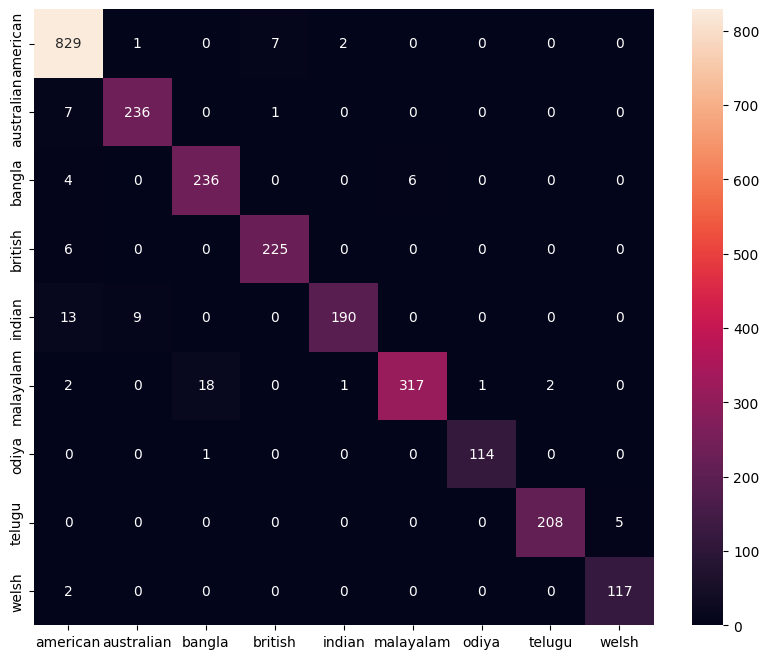

In [106]:
labels = ["american", "australian", "bangla", "british", "indian", "malayalam", "odiya", "telugu", "welsh"]

df_cm = pd.DataFrame(cm, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10, 8))
sn.heatmap(df_cm, annot=True, fmt='g')
# plt.savefig('/content/drive/MyDrive/licenta/confustionMatrix')

## Accuracy and loss plot

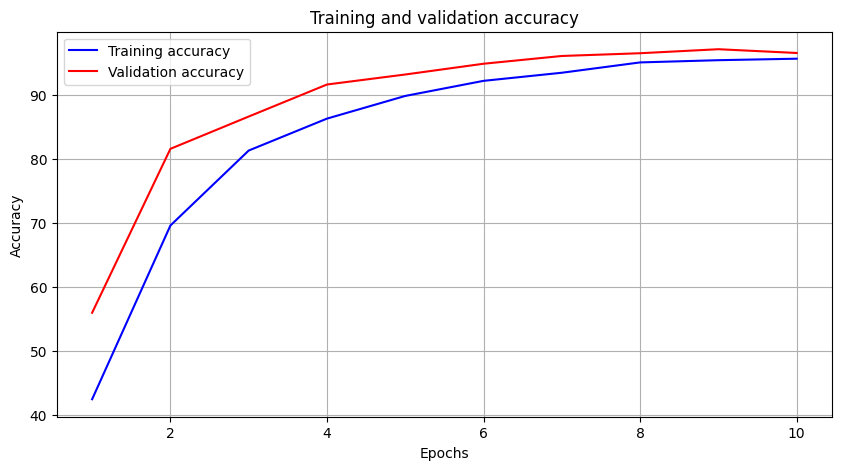

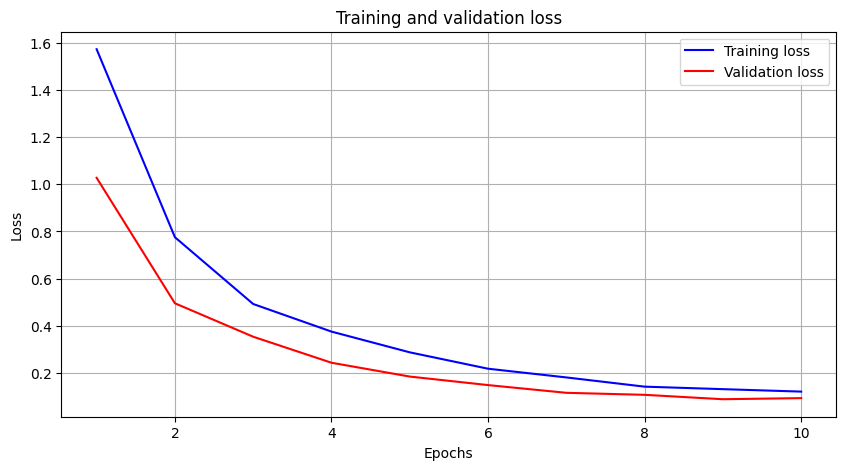

In [107]:
epochs = range(1, hyperparams['num_epochs'] + 1)

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()